In [35]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [36]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [37]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("goubeast/age-prediction-av")
#print("Path to dataset files:", path)

In [38]:
! ls data/train/old


10019.jpg  13515.jpg  17028.jpg  20323.jpg  23707.jpg  3335.jpg  6651.jpg
10040.jpg  13520.jpg  17030.jpg  20407.jpg  23711.jpg  3338.jpg  6685.jpg
10055.jpg  1352.jpg   17037.jpg  20415.jpg  23716.jpg  3344.jpg  6691.jpg
10059.jpg  13535.jpg  17042.jpg  20422.jpg  23717.jpg  3375.jpg  6693.jpg
10063.jpg  13537.jpg  17093.jpg  20431.jpg  23720.jpg  337.jpg	 6696.jpg
10093.jpg  13546.jpg  17095.jpg  20438.jpg  23766.jpg  3386.jpg  6713.jpg
10105.jpg  13558.jpg  17127.jpg  20488.jpg  23781.jpg  3401.jpg  6724.jpg
10116.jpg  13578.jpg  17137.jpg  2051.jpg   23785.jpg  3414.jpg  6732.jpg
10120.jpg  13604.jpg  17142.jpg  20523.jpg  23793.jpg  3421.jpg  6746.jpg
10122.jpg  13622.jpg  17218.jpg  20559.jpg  23824.jpg  342.jpg	 6811.jpg
1013.jpg   13652.jpg  17223.jpg  20569.jpg  23891.jpg  3435.jpg  6880.jpg
10147.jpg  13687.jpg  17227.jpg  2062.jpg   23917.jpg  3436.jpg  6888.jpg
10157.jpg  136.jpg    1722.jpg	 20648.jpg  23921.jpg  3462.jpg  6897.jpg
10168.jpg  13701.jpg  17261.jpg  20656.jp

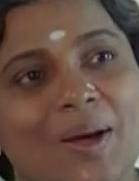

In [39]:
path = './data/train/old'
#name = '82.headshot.jpg'
name = '10019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [40]:
img = load_img(fullname, target_size=(200, 200))
x = np.array(img)
x.shape

(200, 200, 3)

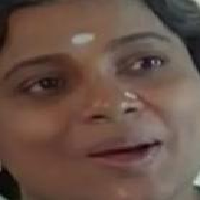

In [41]:
img

Model from scratch

In [42]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [43]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    20,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,073,473 (76.57 MB)

 Trainable params: 20,073,473 (76.57 MB)

 Non-trainable params: 0 (0.00 B)

Transfer learning: Reusing Imagenet model

In [45]:
from keras.applications.xception import Xception

In [61]:
# modify create model function
def create_model(learning_rate=0.001, size_inner=100):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # 2 classes
  outputs = keras.layers.Dense(2)(inner)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model


In [62]:
train_dir = 'data/train'
test_dir = 'data/test'

#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [64]:
train_generator.class_indices

{'old': 0, 'young': 1}

In [65]:
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2277 images belonging to 2 classes.


In [66]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [75]:
# Create checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'#max monitor variable
)

In [68]:
model = create_model()

In [69]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10


I0000 00:00:1737571847.975532    1486 service.cc:148] XLA service 0x7f41500024e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737571847.975565    1486 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-22 18:50:48.068781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737571848.766157    1486 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-22 18:50:51.904549: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  3/342 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.6417 - loss: 0.6423

I0000 00:00:1737571852.768165    1486 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


342/342 ━━━━━━━━━━━━━━━━━━━━ 45s 107ms/step - accuracy: 0.8144 - loss: 0.4083 - val_accuracy: 0.8621 - val_loss: 0.3133
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.8739 - loss: 0.2949 - val_accuracy: 0.8748 - val_loss: 0.2979
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.8959 - loss: 0.2404 - val_accuracy: 0.8810 - val_loss: 0.2990
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9183 - loss: 0.1939 - val_accuracy: 0.8876 - val_loss: 0.2776
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9409 - loss: 0.1529 - val_accuracy: 0.8854 - val_loss: 0.2854
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9508 - loss: 0.1319 - val_accuracy: 0.8937 - val_loss: 0.2942
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9634 - loss: 0.0969 - val_accuracy: 0.8902 - val_loss: 0.2992
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9698 - loss: 0.0836 - val_accura

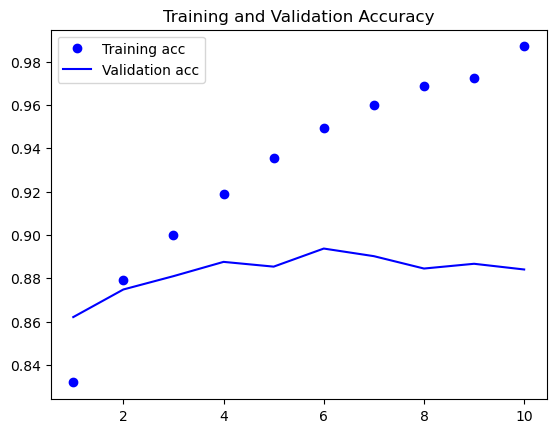

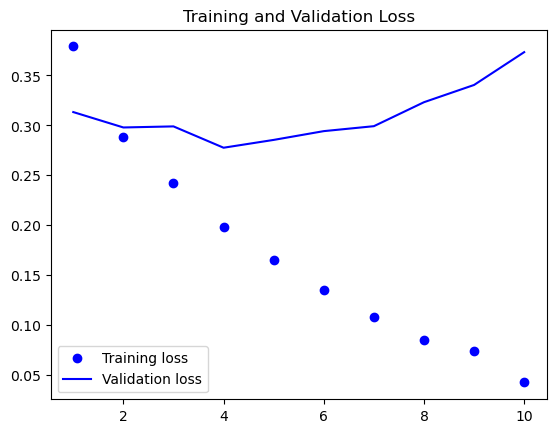

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [72]:
acc_median = np.median(acc)
acc_median

np.float64(0.9425329267978668)

In [73]:
loss_std = np.std(loss)
loss_std

np.float64(0.10077981570257692)

In [87]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [88]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [89]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [90]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2275 images belonging to 2 classes.


In [76]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9958 - loss: 0.0216 - val_accuracy: 0.8849 - val_loss: 0.4288
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9974 - loss: 0.0174 - val_accuracy: 0.8884 - val_loss: 0.4152
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9975 - loss: 0.0127 - val_accuracy: 0.8740 - val_loss: 0.4580
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9918 - loss: 0.0265 - val_accuracy: 0.8779 - val_loss: 0.4314
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9894 - loss: 0.0313 - val_accuracy: 0.8762 - val_loss: 0.5346
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9973 - loss: 0.0134 - val_accuracy: 0.8863 - val_loss: 0.4794
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9996 - loss: 0.0048 - val_accuracy: 0.8924 - val_loss: 0.4957
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 1.0000 - loss: 0.0021 - 

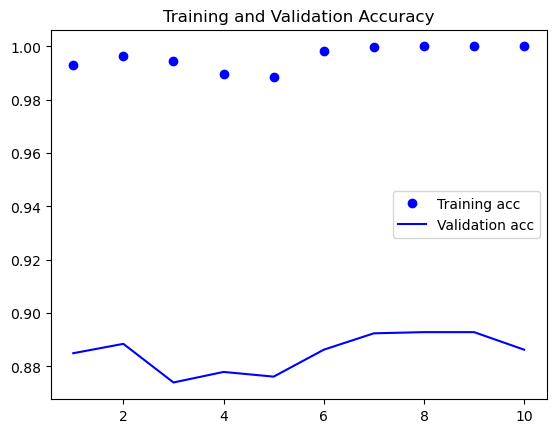

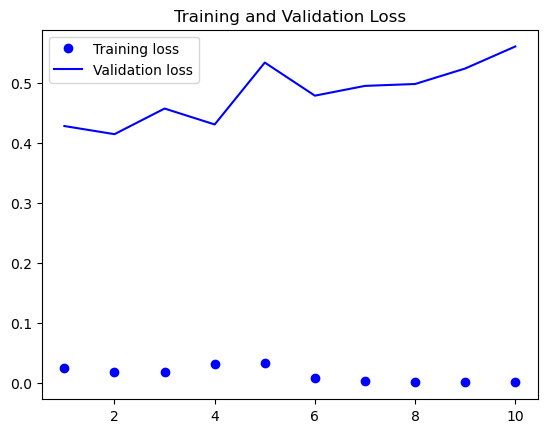

In [78]:
acc_aug = history.history['accuracy']
val_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [79]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

np.float64(0.4828305453062057)

In [80]:
val_acc_aug[5:10]

[0.886253833770752,
 0.8924022912979126,
 0.8928414583206177,
 0.8928414583206177,
 0.886253833770752]

In [81]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

np.float64(0.8901185750961303)

Using a saved model via checkpoint

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [83]:
model = keras.models.load_model('xception_v1_08_0.893.keras')

In [84]:
model.evaluate(validation_generator)

114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8874 - loss: 0.5306


[0.49888983368873596, 0.8928414583206177]

In [95]:
path = 'data/test/young/10056.jpg'
img = load_img(path, target_size=(200, 200))

In [96]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape

(1, 200, 200, 3)

In [97]:
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [98]:
pred[0]

array([-1.584364 ,  1.1029187], dtype=float32)

In [99]:
import tensorflow as tf

probabilities = tf.nn.softmax(pred[0]).numpy()
print(probabilities)

[0.06372795 0.936272  ]


Convert model to TF-Lite

In [128]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzh2mqdgb/assets


INFO:tensorflow:Assets written to: /tmp/tmpzh2mqdgb/assets


Saved artifact at '/tmp/tmpzh2mqdgb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140043279556176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140043279554256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140043279557712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140043279558672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140043279558864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140043279559440: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1737492211.410810    1554 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737492211.410835    1554 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 20:43:31.411375: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzh2mqdgb
2025-01-21 20:43:31.412390: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 20:43:31.412409: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpzh2mqdgb
I0000 00:00:1737492211.417887    1554 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-21 20:43:31.418883: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 20:43:31.504654: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpzh2mqdgb
2025-01-21 20:43:31.515213: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 